In [41]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import pgeocode
warnings.filterwarnings("ignore")

In [8]:
# df = original database with dropped null values
# df_3 = transforming sell date feature to individual month and year
# df_4 = clean condition feature
# df_5 = convert zipcode to place-name and state
# df_6 = relabel catagorical & numerical features

In [9]:
db = sqlite3.connect('home_sales.db')
df = pd.read_sql_query('SELECT * FROM sales;',db)

In [10]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'floors', 'waterfront',
       'view', 'condition', 'review_score', 'basement_size', 'built',
       'renovation', 'zipcode', 'latitude', 'longitude', 'living_room_size',
       'lot_size'],
      dtype='object')

## Understanding housing price
House price is the main feature we are trying analyze with respect to all the other features. Therefore it is important to understand the shape and distribution. With this information, we will make important decision later during the data preprocessing phase.

In [142]:
df['price'].describe()

count    1.968800e+04
mean     5.434626e+05
std      3.733997e+05
min      7.500000e+04
25%      3.230000e+05
50%      4.520000e+05
75%      6.500000e+05
max      7.700000e+06
Name: price, dtype: float64

Skewness:  4.102170944904706
Kurtosis:  35.801754777271405


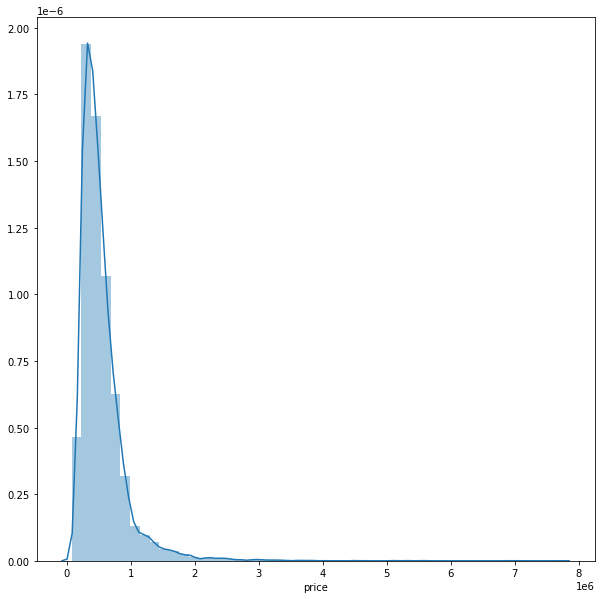

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df['price'])
print("Skewness: ", df['price'].skew())
print("Kurtosis: ",df['price'].kurt())

((array([-4.01331518, -3.79891833, -3.68167598, ...,  3.68167598,
          3.79891833,  4.01331518]),
  array([75000., 78000., 80000., ...,    nan,    nan,    nan])),
 (nan, nan, nan))

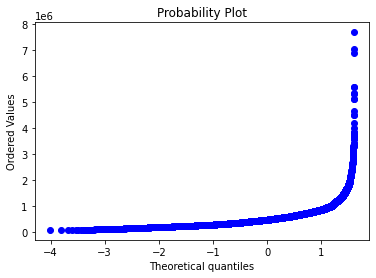

In [15]:
stats.probplot(df['price'],plot=plt)

Based on the distribution plot and skewness value of 4.1, we can identify that price feature is approximately normally distributed with a right skew. We would have to apply log transformation to price feature at a later stage during data preprocessing before we can use any linear regression techniques.

<AxesSubplot:xlabel='price'>

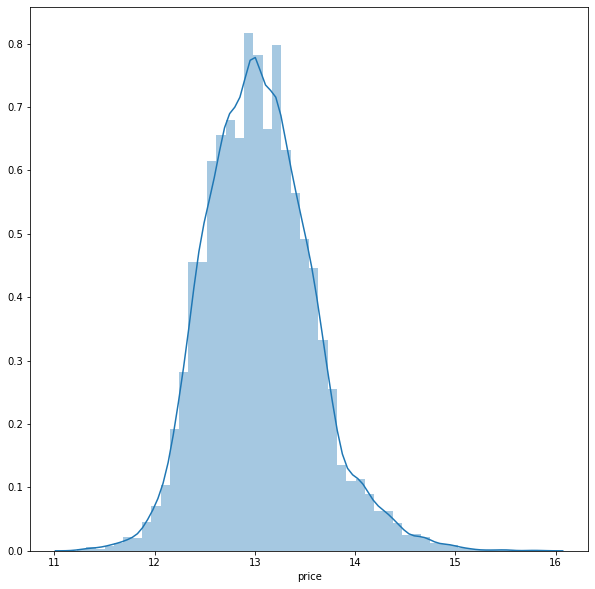

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot(np.log1p(df['price']))
print("Skewness: ", df['price'].skew())
print("Kurtosis: ",df['price'].kurt())

((array([-4.01331518, -3.79891833, -3.68167598, ...,  3.68167598,
          3.79891833,  4.01331518]),
  array([11.22525673, 11.26447693, 11.28979441, ...,         nan,
                 nan,         nan])),
 (nan, nan, nan))

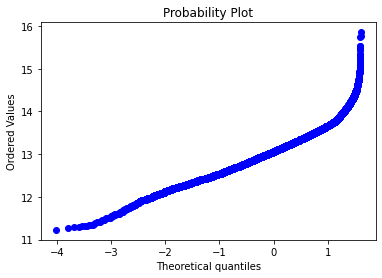

In [14]:
stats.probplot(np.log1p(df['price']),plot=plt)

After transformation, we can still see deviations above 1 of theoretical quantiles.

## Analyzing data quality & identifying null values

In [16]:
NANp = [(c, df[c].isna().mean()*100) for c in df]
NANs = [(c, df[c].isna().sum()) for c in df]
NANp = pd.DataFrame(NANp, columns=["column_name", "percentage"])
NANs = pd.DataFrame(NANs, columns=["column_name", "sum"])
NAN = pd.concat([NANp,NANs['sum']],axis=1).sort_values("percentage", ascending=False)
NAN

,column_name,percentage,sum
9,review_score,5.627537,1303
11,built,5.618900,1301
5,floors,5.580029,1292
6,waterfront,5.541159,1283
0,id,5.541159,1283
15,longitude,5.489332,1271
13,zipcode,5.485013,1270
8,condition,5.459100,1264
2,price,5.433186,1258
12,renovation,5.428868,1257


In [17]:
# remove null values before analysis
print("before drop: ",df.shape)
df = df.dropna()
print("after drop: ",df.shape)

before drop:  (23154, 18)
after drop:  (19688, 18)


The database is showing around 5-6% of null data. We shall drop these rows before continuing to analyze our data.

## Analyzing features individually

We shall first perform uni-variate analysis on individual features with respect to house prices to uncover and explore data insights that were previously hidden. With this knowledge and insights, we can make better decision in feature engineering; for example, whether to drop a certain feature if they do not help in regression or classification.

These insights can also be used by property agents both to better understand how significant an impact does each feature have on housing prices and also to validate or overturn some of their preconceived notion of certain characteristics of a house.We shall first perform uni-variate analysis on individual features with respect to house prices to uncover and explore data insights that were previously hidden. With this knowledge and insights, we can make better decision in feature engineering; for example, whether to drop a certain feature if they do not help in regression or classification. 

These insights can also be used by property agents both to better understand how significant an impact does each feature have on housing prices and also to validate or overturn some of their preconceived notion of certain characteristics of a house. 

### Transforming and analysing sale date

In [19]:
df_datebefore = df.loc[:,'date']
df_dateafter = pd.DataFrame(columns=['sell-month','sell-year'])

In [20]:
for index, row in enumerate(df_datebefore):
    try:
        dateArray = row.split()
        df_dateafter.loc[index,'sell-month'] = dateArray[1]
        df_dateafter.loc[index,'sell-year'] = dateArray[2]
        
    except:
        pass
        

In [21]:
df_2 = pd.concat([df,df_dateafter],axis=1)

In [22]:
df_3 = df_2.loc[(df_2['sell-month'] == 'January') | 
         (df_2['sell-month'] == 'February' )| 
         (df_2['sell-month'] == 'March') |
         (df_2['sell-month'] == 'April') |
         (df_2['sell-month'] == 'May') | 
         (df_2['sell-month'] == 'June') |
         (df_2['sell-month'] == 'July') |
         (df_2['sell-month'] == 'August') |
         (df_2['sell-month'] == 'September') |
         (df_2['sell-month'] == 'October') |
         (df_2['sell-month'] == 'November') |
         (df_2['sell-month'] == 'December')]

In [23]:
# Identifying all spelling used for sell-month feature
# df_2.groupby('sell-month').count().sort_values('id',ascending = False).reset_index()['sell-month'].tolist()

In [24]:
# Identify most common spelling
# df_2.groupby('sell-month').count().sort_values('id',ascending = False)

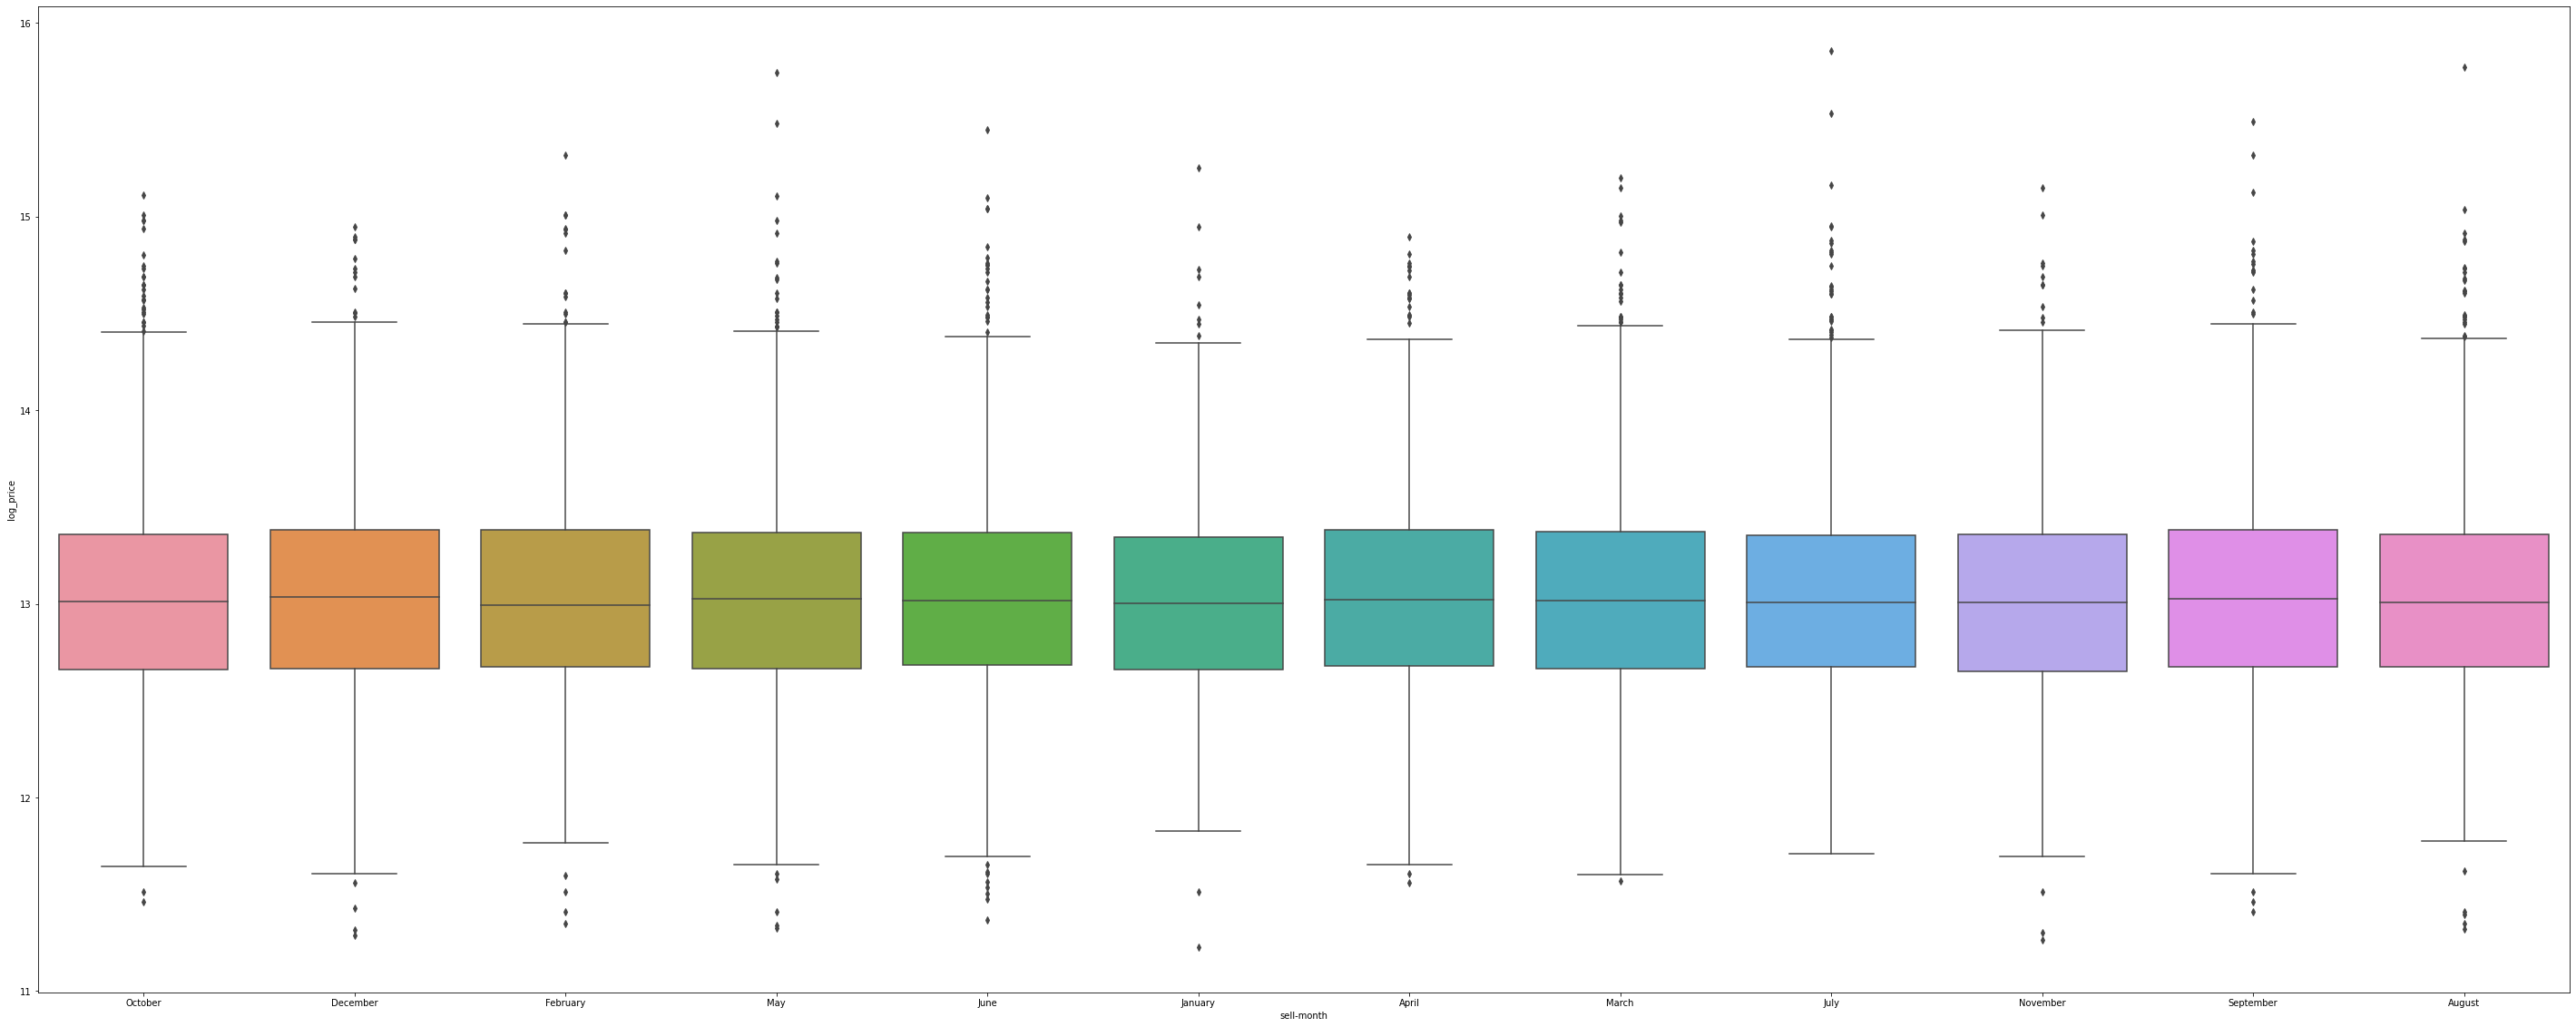

In [42]:
#box plot price vs sell-month
df_3['log_price'] = np.log1p(df_3['price'])
f, ax = plt.subplots(figsize=(50, 20))
fig = sns.boxplot(x='sell-month',y="log_price", data=df_3)

When it comes to house prices, time of the month when sales transaction occur does not seem to be impacting price in terms of distribution.

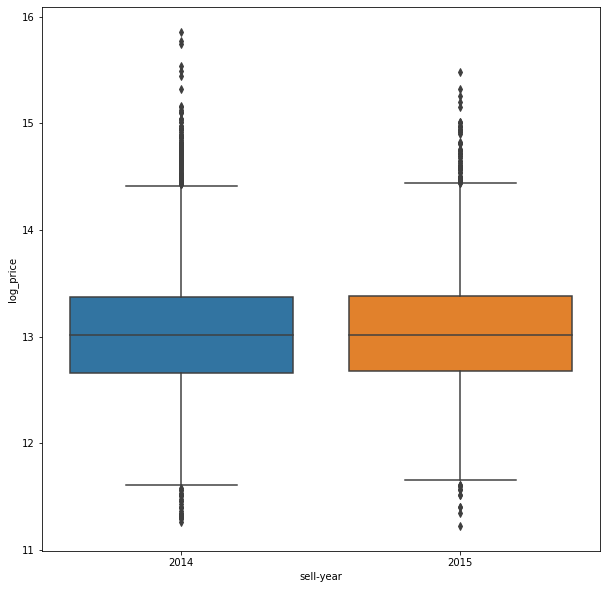

In [32]:
#box plot price vs sell-year
f, ax = plt.subplots(figsize=(10, 10))
fig = sns.boxplot(x='sell-year',y="log_price", data=df_3)

There also does not seem to have a corelation between year and price. We observe that in 2015 there has not been a sale of any extremely expensive property.

### Let's analyse physical living spaces (bedrooms, bathrooms, floors, waterfront, view, basement_size, living_room_size)

For phyiscal features of housing, we have:
1. Discrete features: bedrooms, bathrooms, floors, waterfront, view 
2. Continuous features: basement_size, living_room_size

It is quite certainly that these phyiscal features would definitely impact housing prices, however, we would have to analyze in detail how significant these impact are on housing prices.

In [33]:
print(df_3.groupby('bedrooms')['id'].count().sort_values(ascending=False))
print(df_3.groupby('bathrooms')['id'].count().sort_values(ascending=False))
print(df_3.groupby('floors')['id'].count().sort_values(ascending=False))
print(df_3.groupby('waterfront')['id'].count().sort_values(ascending=False))
print(df_3.groupby('view')['id'].count().sort_values(ascending=False))

bedrooms
3.0     7605
4.0     5223
2.0     2107
5.0     1186
6.0      204
1.0      155
7.0       36
0.0       11
8.0        9
9.0        4
10.0       3
11.0       1
Name: id, dtype: int64
bathrooms
2.50    3844
1.00    3188
1.75    2505
2.25    1578
2.00    1569
1.50    1138
2.75     864
3.00     558
3.50     457
3.25     396
3.75     106
4.00      87
4.50      63
4.25      58
0.75      58
4.75      13
5.00      13
5.25      11
0.00       9
5.50       7
5.75       4
6.00       4
1.25       4
0.50       3
6.25       2
8.00       2
7.75       1
6.75       1
7.50       1
Name: id, dtype: int64
floors
1.0    8885
2.0    5673
1.5    1588
3.0     287
2.5     106
3.5       5
Name: id, dtype: int64
waterfront
0.0    16405
1.0      139
Name: id, dtype: int64
view
0.0    14839
2.0      768
3.0      408
1.0      268
4.0      261
Name: id, dtype: int64


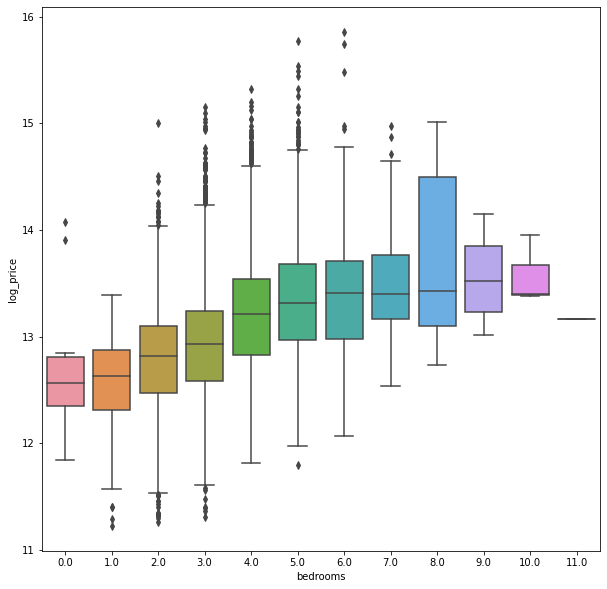

In [64]:
f, ax = plt.subplots(figsize=(10, 10))
fig = sns.boxplot(x='bedrooms',y="log_price", data=df_3)

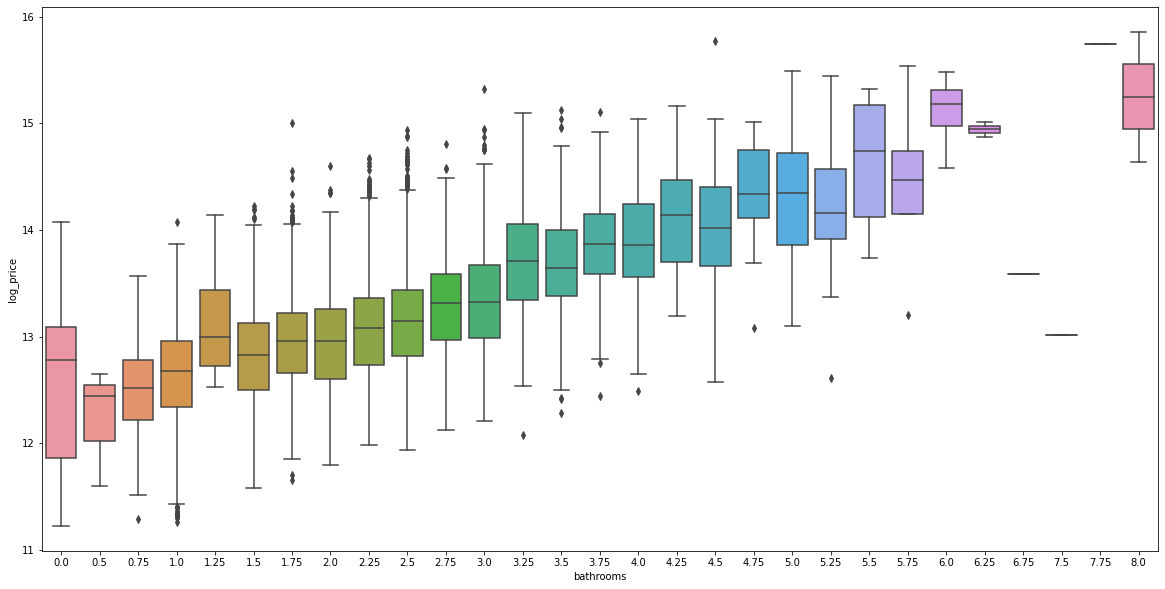

In [63]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x='bathrooms',y="log_price", data=df_3)

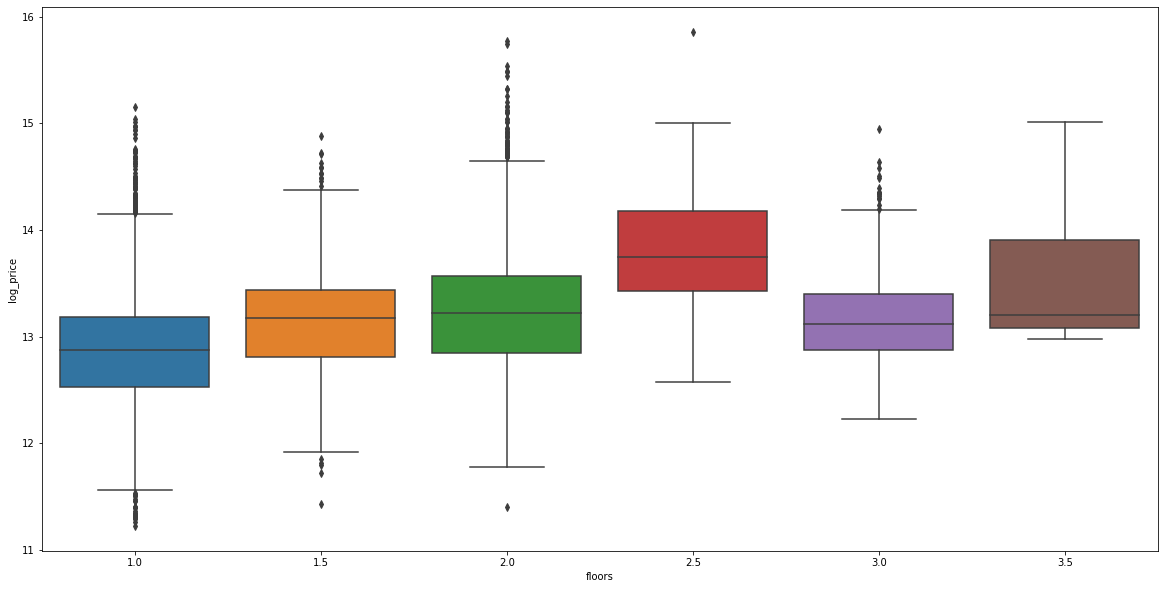

In [62]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x='floors',y="log_price", data=df_3)

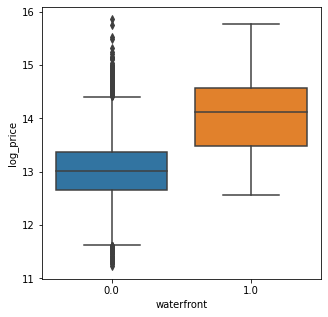

In [61]:
f, ax = plt.subplots(figsize=(5, 5))
fig = sns.boxplot(x='waterfront',y="log_price", data=df_3)

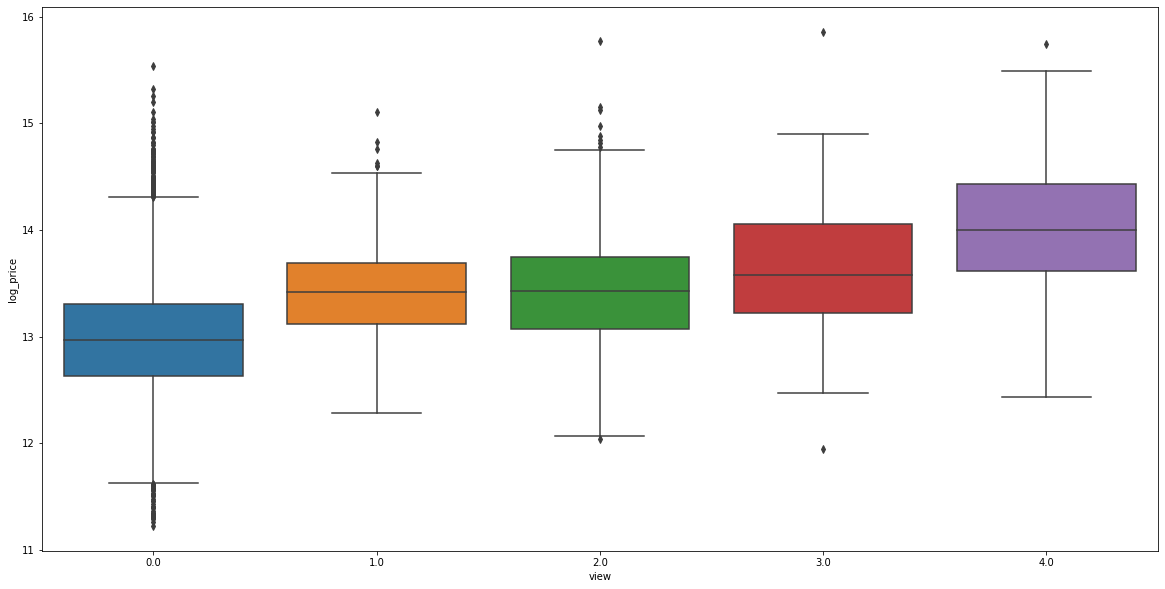

In [60]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x='view',y="log_price", data=df_3)

                 id       
waterfront      0.0    1.0
view                      
0.0         14839.0    0.0
1.0           267.0    1.0
2.0           761.0    7.0
3.0           391.0   17.0
4.0           147.0  114.0


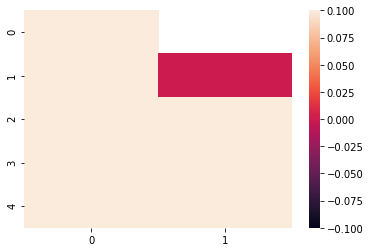

In [44]:
data = pd.pivot_table(df_3,index=['view'],columns=['waterfront'],values=['id'],aggfunc=len).fillna(0).reset_index().set_index('view')
ax = sns.heatmap(np.log(data.to_numpy()))
print(data)

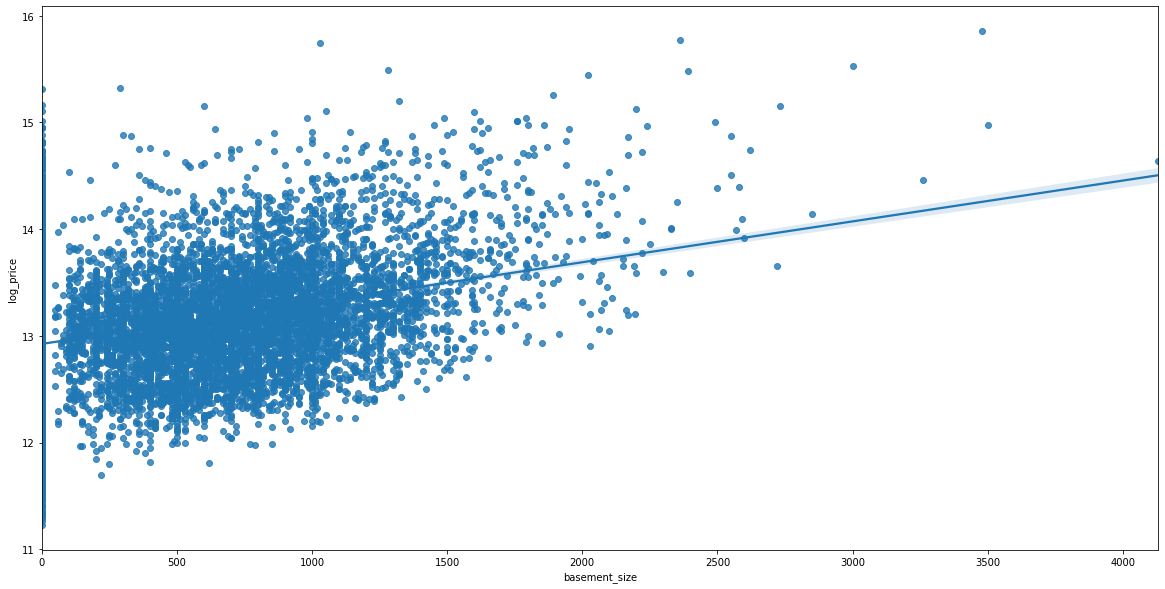

In [67]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.regplot(x='basement_size',y="log_price", data=df_3)

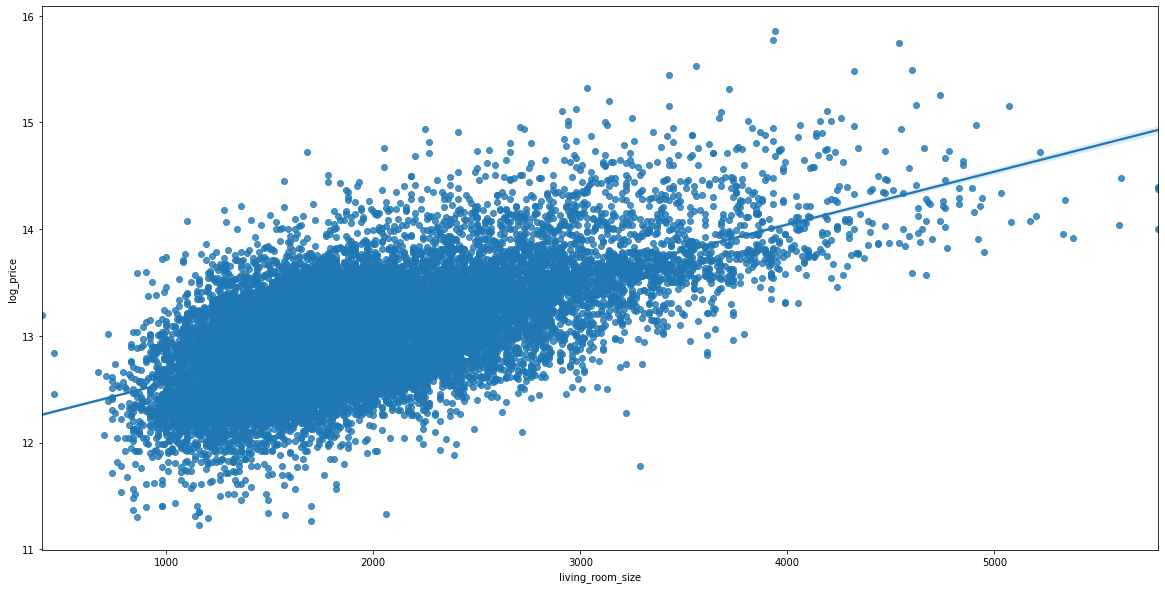

In [68]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.regplot(x='living_room_size',y="log_price", data=df_3)

These insights can also be used by property agents both to better understand how significant an impact does each feature have on housing prices and also to validate or overturn some of their preconceived notion of certain characteristics of a house.We shall first perform uni-variate analysis on individual features with respect to house prices to uncover and explore data insights that were previously hidden. With this knowledge and insights, we can make better decision in feature engineering; for example, whether to drop a certain feature if they do not help in regression or classification.

These insights can also be used by property agents both to better understand how significant an impact does each feature have on housing prices and also to validate or overturn some of their preconceived notion of certain characteristics of a house.There are obviously corelation between home price vs bedroom and bathrooms. Looking at the data, it is interesting to observe that bathrooms are not whole numbers, with increments of 0.25. Also interesting to note there are a few numbers of properties with 0 bathrooms with prices that are higher than properties with more than 0.75 bathrooms, showing that there are definitely other features that are affecting pricing more (location, condition, etc.)

There is a general increment in price as floors increases. But looking at floors higher than 3, we see a general drop in price. There might be a general preference amongst home buyers to keep their homes below 3 floors. We also observed an overall increase in price between whole number floors and the 0.5 increment of it. The 0.5 might represent rooftop access and hence it would make some sense that home buyers would prefer houses with rooftops as there are more utlity value to it. (eg: farming, roof top parties, etc.)

There is also a clear increment in price between properties with waterfront versus proporties without waterfront. Most properties with waterfront has a view rating of 4.0 and most properties without a waterfront has a 0.0 view rating. With an amazing view, such properties likely come with a premium as there is a clear increase in price for properties with a higher view rating.

### Let's analyse other factors affecting housing prices (condition, review_score, built, renovation, location: zipcode, latitude, longitude)

In [45]:
# clean condition feature and represent it with a contextualized number
df_4 = df_3
df_4.loc[df_4.condition == 'TERRIBLE'] = df_4.loc[df_4.condition == 'TERRIBLE'].replace("TERRIBLE","0")
df_4.loc[df_4.condition == 'terrible'] = df_4.loc[df_4.condition == 'terrible'].replace("terrible","0")
df_4.loc[df_4.condition == 'POOR'] = df_4.loc[df_4.condition == 'POOR'].replace("POOR","1")
df_4.loc[df_4.condition == 'poor'] = df_4.loc[df_4.condition == 'poor'].replace("poor","1")
df_4.loc[df_4.condition == 'FAIR'] = df_4.loc[df_4.condition == 'FAIR'].replace("FAIR","2")
df_4.loc[df_4.condition == 'fair'] = df_4.loc[df_4.condition == 'fair'].replace("fair","2")
df_4.loc[df_4.condition == 'GOOD'] = df_4.loc[df_4.condition == 'GOOD'].replace("GOOD","3")
df_4.loc[df_4.condition == 'good'] = df_4.loc[df_4.condition == 'good'].replace("good","3")
df_4.loc[df_4.condition == 'EXCELLENT'] = df_4.loc[df_4.condition == 'EXCELLENT'].replace("EXCELLENT","4")
df_4.loc[df_4.condition == 'excellent'] = df_4.loc[df_4.condition == 'excellent'].replace("excellent","4")

In [46]:
print(df_4.groupby('condition')['id'].count().sort_values(ascending=False))
print(df_4.groupby('review_score')['id'].count().sort_values(ascending=False))
print(df_4.groupby('built')['id'].count().sort_values(ascending=False))
print(df_4.groupby('renovation')['id'].count().sort_values(ascending=False))

condition
2    10188
3     4772
4     1418
1      138
0       28
Name: id, dtype: int64
review_score
7.0     6875
8.0     4653
9.0     2011
6.0     1563
10.0     875
11.0     285
5.0      181
12.0      69
4.0       19
13.0      10
3.0        2
1.0        1
Name: id, dtype: int64
built
1977.0    351
2003.0    340
1978.0    338
2004.0    326
1968.0    315
         ... 
1901.0     25
1902.0     22
1935.0     20
1934.0     17
2015.0      9
Name: id, Length: 116, dtype: int64
renovation
0.0       15759
2014.0       75
2013.0       31
2003.0       31
2005.0       30
          ...  
1950.0        1
1951.0        1
1959.0        1
1971.0        1
1954.0        1
Name: id, Length: 70, dtype: int64


I first will analyze condition feature (between 0 to 4) and review feature (between 0 to 12) as discrete features. Renovation and Build feature will be analyzed as continuous feature.

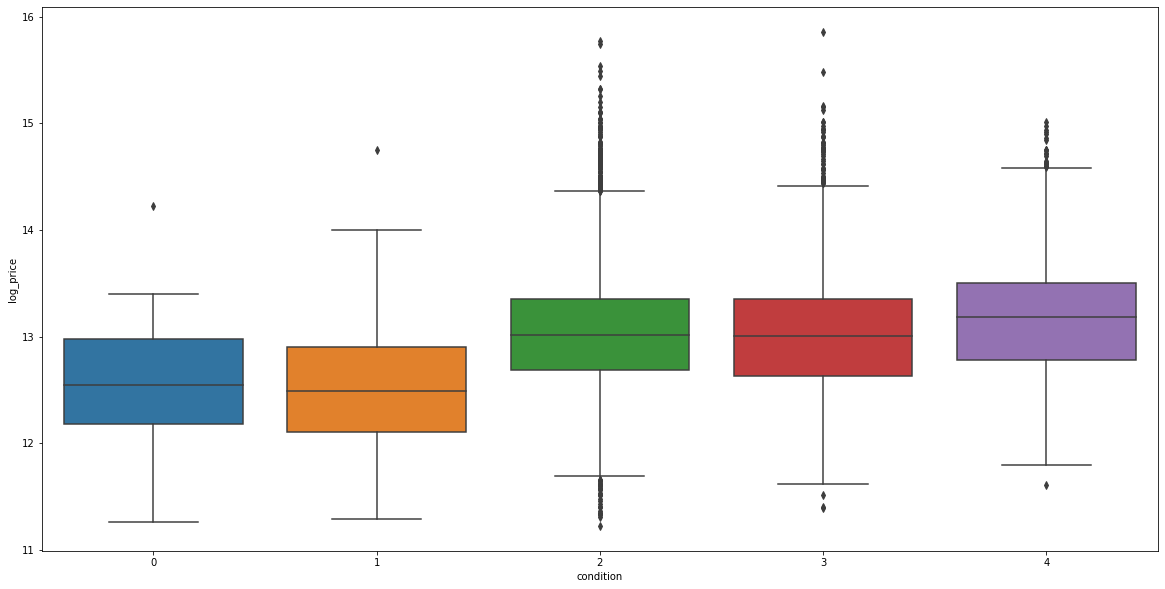

In [57]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x='condition',y="log_price", data=df_4,order=['0','1','2','3','4'])

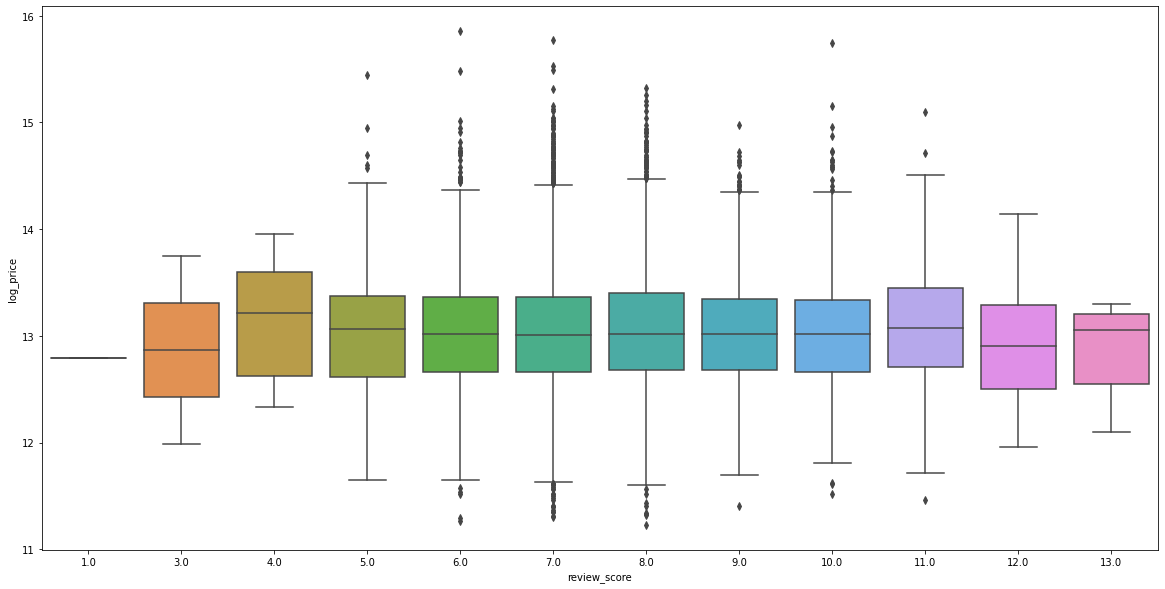

In [59]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x='review_score',y="log_price", data=df_4)

Clearly the better the condition of the property, the higher the housing price. However the value of the house does not increase beyond a condition value of 2.

There is surprisingly no distinct evidence that a better review score translated to a higher housing price. This makes us question the source of these reviews as clearly one cannot trust the quality of the review in predicting the cost of house price in USA.

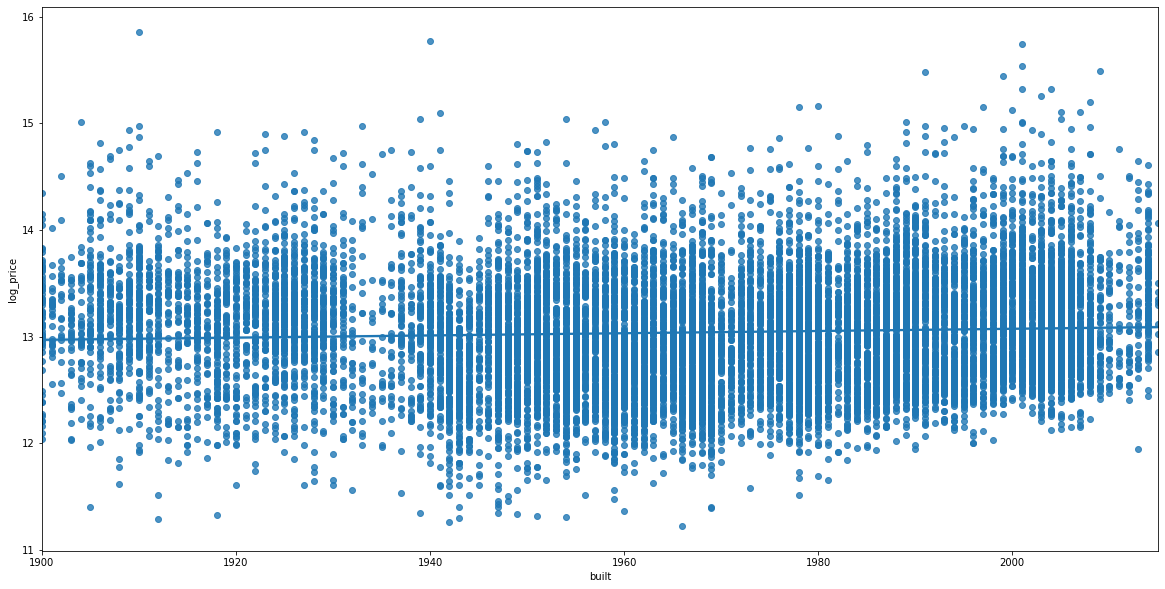

In [66]:
df_4['log_price'] = np.log(df_4['price'])
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.regplot(x='built',y="log_price", data=df_4)

There is a slight positive corelation between price and year build, showing that people generally value a newer property compared to old property. However, it should also be noted that the condition of an old houses drastically improve after renovation. This might be one of the reason why there is only a slightly positive corelation between built year and price.

<AxesSubplot:xlabel='built'>

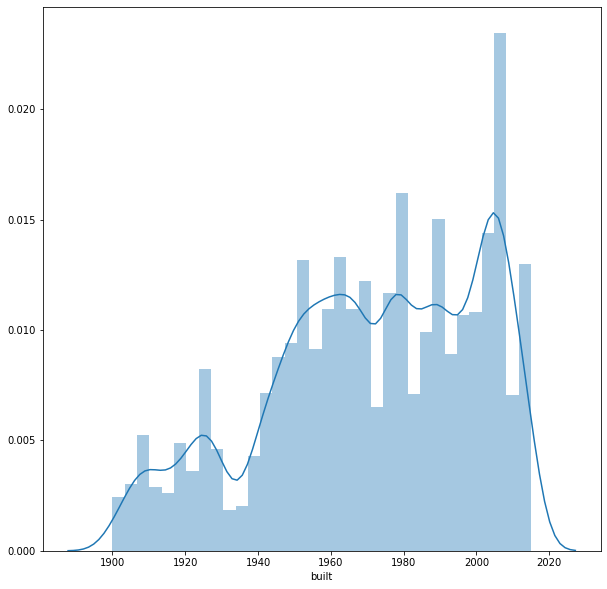

In [69]:
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df['built'])

Observing the distribution of when properties are build, we can see that there are a lot more properties built after 1950s, with a major spike in properties built in around 2008 to 2010. (This data supports the impact of the housing bubble USA faced in 2008)

In [77]:
df_4['hasRenovation'] = df_4['renovation']
df_4.loc[df_4.hasRenovation != 0,'hasRenovation'] = 'yes'
df_4.loc[df_4.hasRenovation == 0, 'hasRenovation'] = 'no'

In [78]:
df_4.groupby('hasRenovation')['id'].count().sort_values(ascending=False).reset_index()

,hasRenovation,id
0,no,15759
1,yes,785


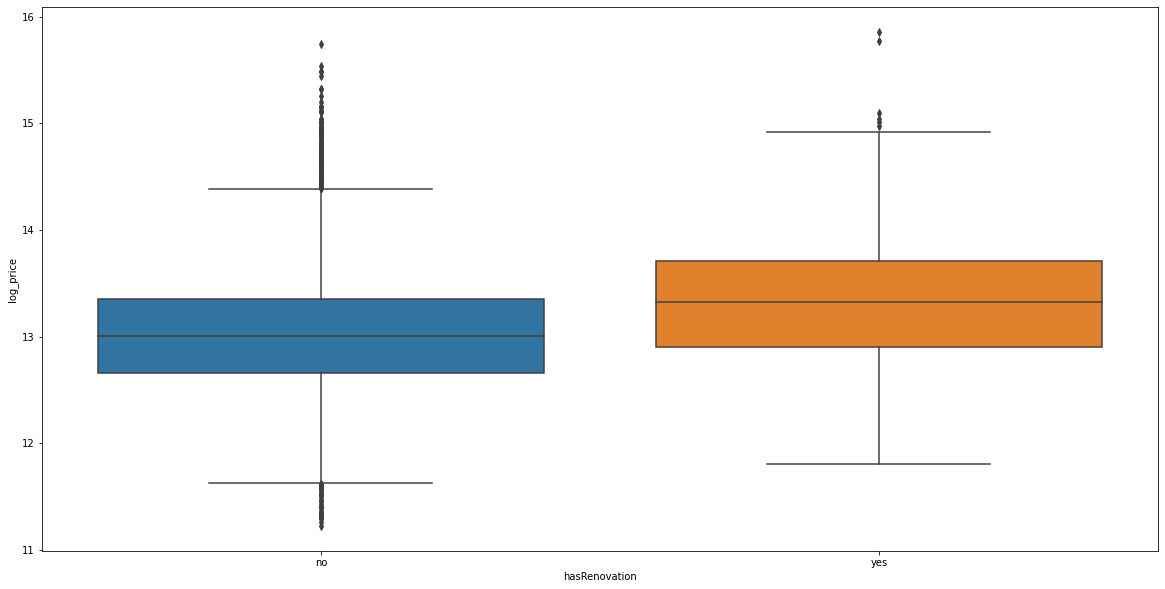

In [79]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x='hasRenovation',y="log_price", data=df_4)

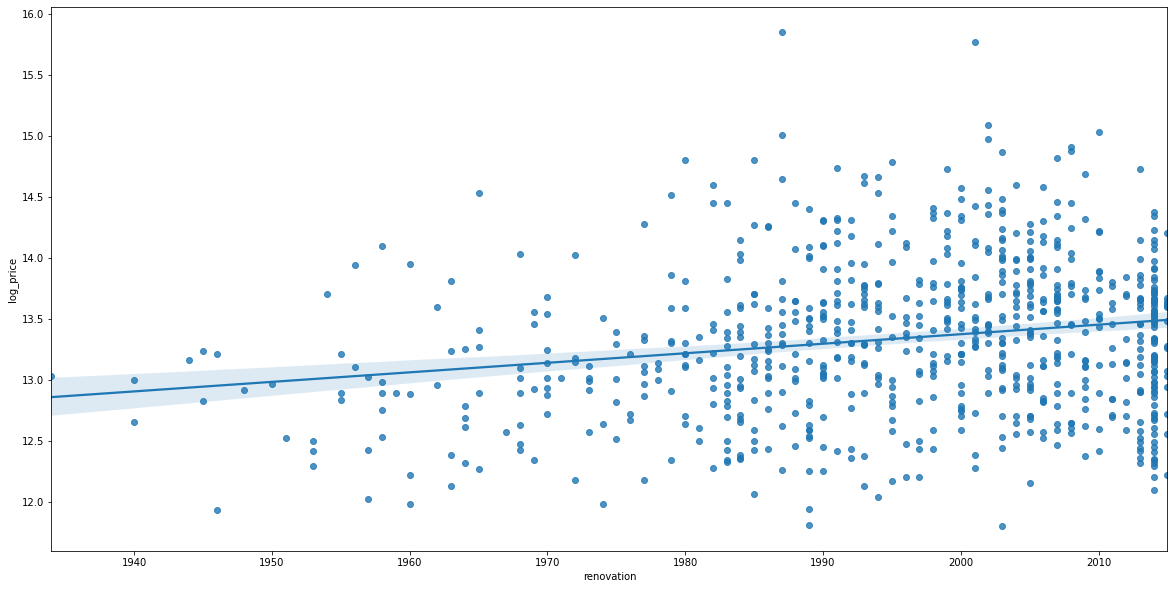

In [81]:
df_reno = df_4.loc[df_4.renovation != 0]
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.dist(x='renovation',y="log_price", data=df_reno)

Clearly we can see that properties that have gone through renovations are price higher than ones that did not go through renovations.

<AxesSubplot:xlabel='deltaRenovate'>

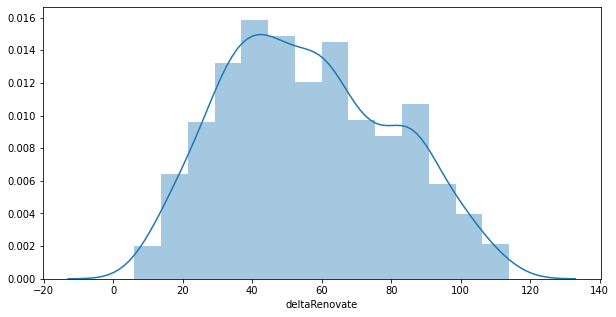

In [97]:
df_4['deltaRenovate'] = df_4['renovation'] - df['built']
df_delta = df_4.loc[df_4['deltaRenovate'] >= 0]
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_delta['deltaRenovate'])

We see that on average home owners would renovate their house around 40-60 years after the house is built. This data could be useful for business development or sales executives working in a renovation firm to reach out to home owners who belong in this catagories.

In [98]:
nomi = pgeocode.Nominatim('us')
locObj = nomi.query_postal_code(int(df_4.loc[0,'zipcode']))
locObj

postal_code            98178
country code              US
place_name           Seattle
state_name        Washington
state_code                WA
county_name             King
county_code               33
community_name           NaN
community_code           NaN
latitude             47.4924
longitude           -122.236
accuracy                   4
Name: 0, dtype: object

We will be using a python library developed by https://pypi.org/project/pgeocode/ to convert zipcode, lat, log data to locations on the USA map.

In [99]:
df_5 = df_4
df_5 = df_5.drop(columns=['sell-month'])
print("before drop: ",df_5.shape)
df_5 = df_5.dropna()
print("after drop: ",df_5.shape)

before drop:  (19467, 23)
after drop:  (16544, 23)


In [100]:
for index, row in df_5.iterrows():
    locObj = nomi.query_postal_code(int(row['zipcode']))
    df_5.loc[index,'state'] = locObj.state_code
    df_5.loc[index,'place_name'] = locObj.place_name

In [101]:
print(df_5.groupby('state')['id'].count().sort_values(ascending=False))
print(df_5.groupby('place_name')['price'].quantile(.5).sort_values(ascending=False))

state
WA    16544
Name: id, dtype: int64
place_name
Medina           1892500.0
Mercer Island     984000.0
Bellevue          739000.0
Sammamish         672500.0
Redmond           600000.0
Woodinville       585000.0
Issaquah          574475.0
Kirkland          496000.0
Snoqualmie        479500.0
Vashon            463750.0
Bothell           462500.0
Fall City         457000.0
Seattle           455000.0
Kenmore           433000.0
Carnation         406500.0
Duvall            400000.0
North Bend        372000.0
Black Diamond     347500.0
Renton            345000.0
Maple Valley      336500.0
Enumclaw          283000.0
Kent              279000.0
Federal Way       266000.0
Auburn            264000.0
Name: price, dtype: float64


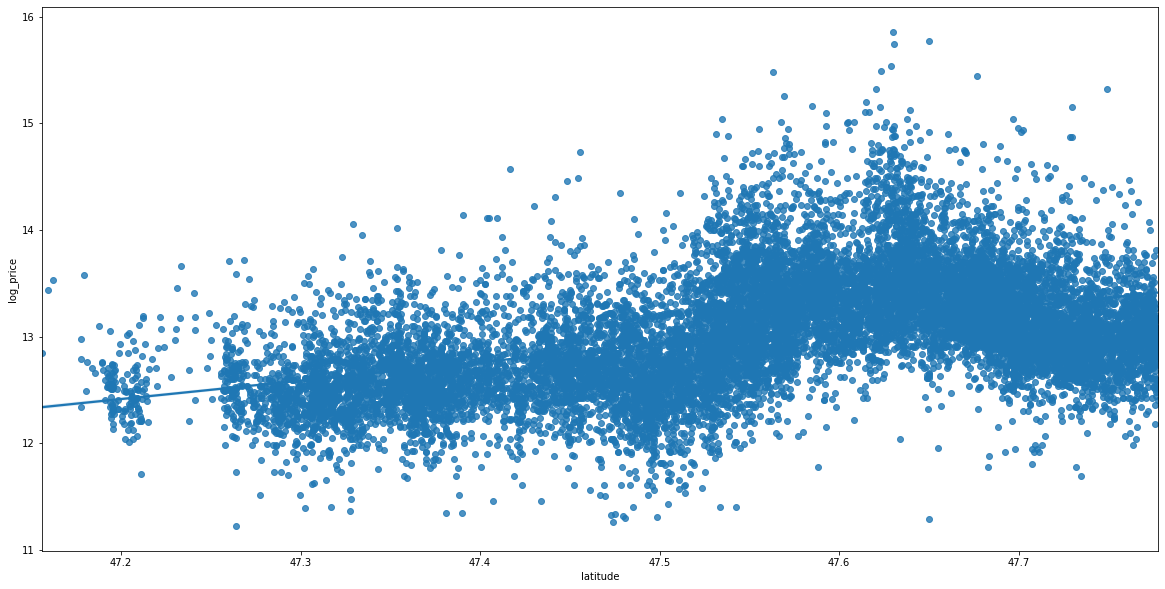

In [138]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.regplot(x="latitude",y="log_price", data=df_5)

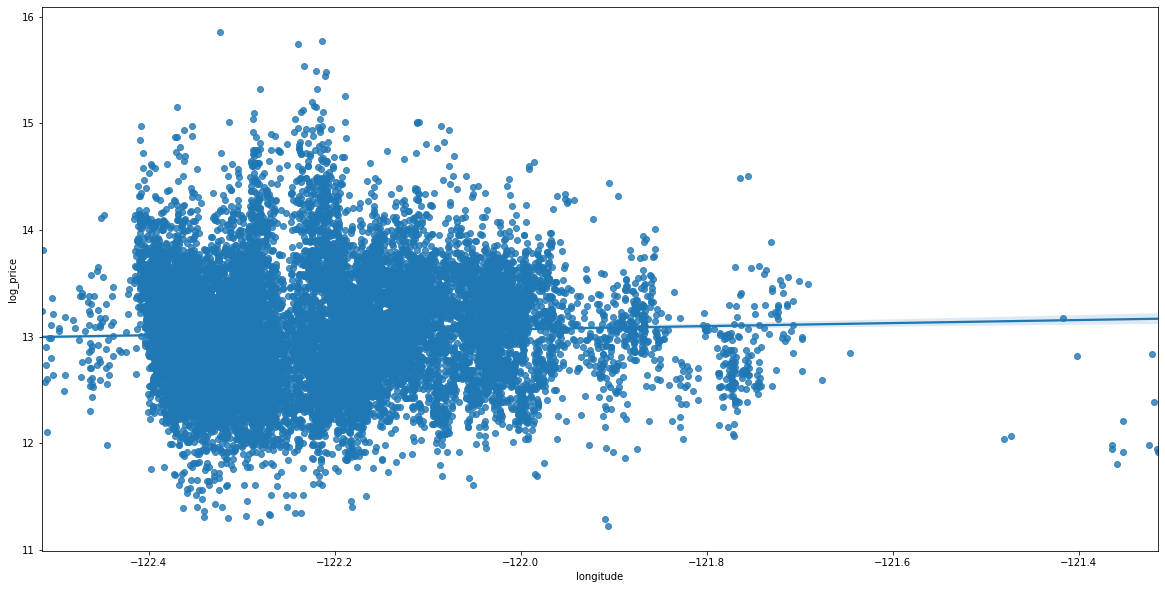

In [139]:
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.regplot(x="longitude",y="log_price", data=df_5)

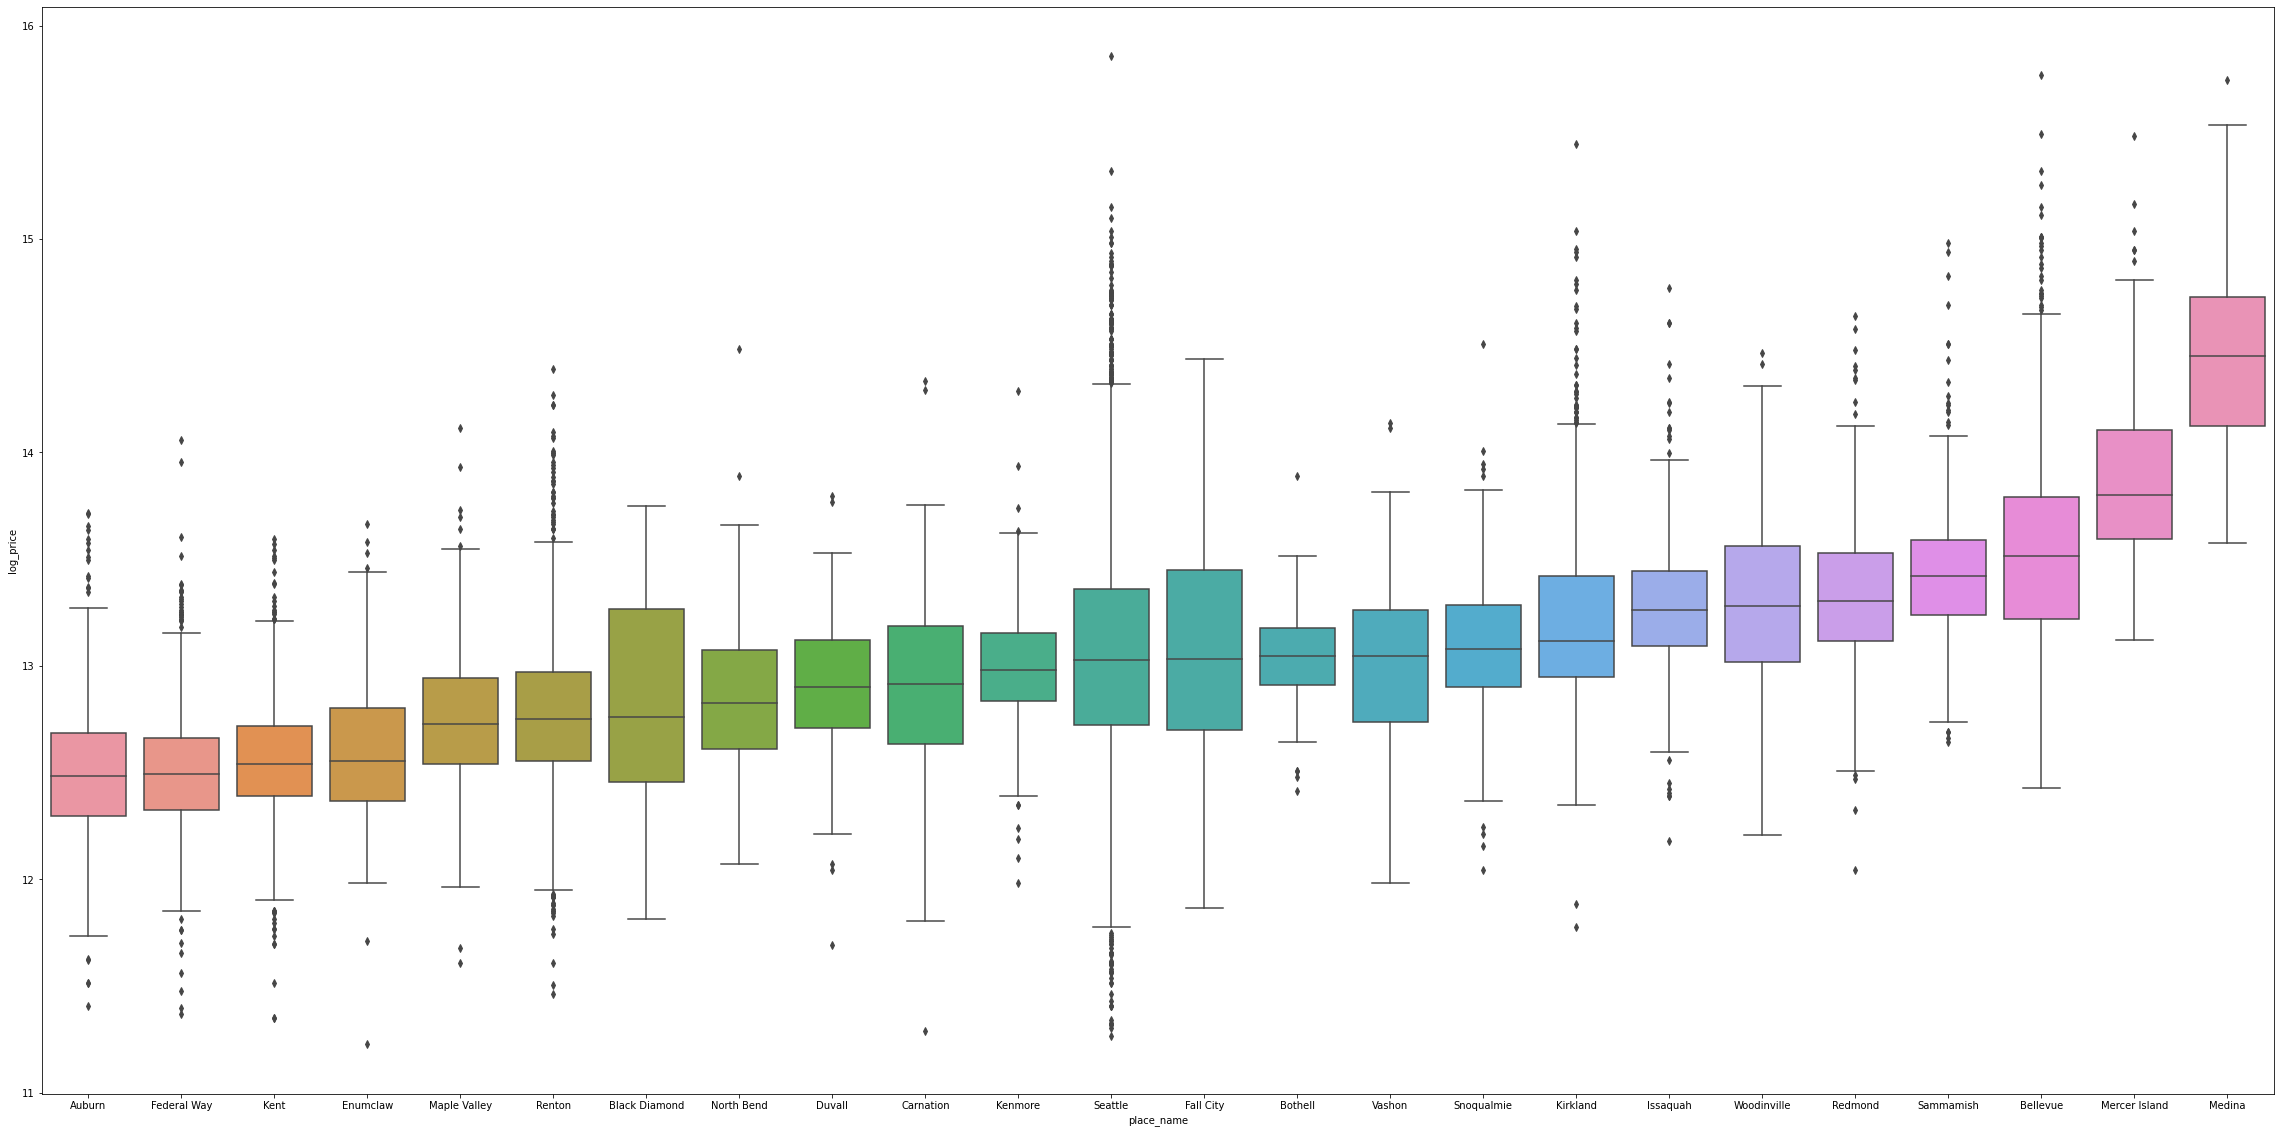

In [103]:
f, ax = plt.subplots(figsize=(40, 20))
fig = sns.boxplot(x="place_name",y="log_price", data=df_5, order = ['Auburn','Federal Way','Kent','Enumclaw','Maple Valley','Renton','Black Diamond','North Bend','Duvall','Carnation','Kenmore','Seattle','Fall City','Bothell','Vashon','Snoqualmie','Kirkland','Issaquah','Woodinville','Redmond','Sammamish','Bellevue','Mercer Island','Medina'])

Location of all housing information are all within Washington state. With the most properties being in Seattle. Properties in places like Bellevue, Mercer Island and Medina typically command a higher selling price compared to the rest of the houses. It should also be noted for regression and classification, models trained from this dataset might not predict well for properties outside of Washington state due to data bias and not a good representation of the properties of the entire USA as a whole. A transformation might be required prior to resolve this issue.

We also note that latitude feature has a stronger corelation than lontitude information, suggesting home buyers who are looking to move houses from the South to the North would have to pay a higher home prices.

## Lets look at the overall data as a whole and analyze the corelation heatmap

In [116]:
df_6 = df_5
df_6 = df_6.replace({
    'sell-month': {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},
    'hasRenovation': {'yes':1,'no':0},
    'place_name': {'Auburn':1,'Federal Way':2,'Kent':3,'Enumclaw':4,'Maple Valley':5,'Renton':6,'Black Diamond':7,'North Bend':8,'Duvall':9,'Carnation':10,'Kenmore':11,'Seattle':12,'Fall City':13,'Bothell':14,'Vashon':15,'Snoqualmie':16,'Kirkland':17,'Issaquah':18,'Woodinville':19,'Redmond':20,'Sammamish':21,'Bellevue':22,'Mercer Island':23,'Medina':24}
})


In [123]:
df_6.dtypes

id                  float64
date                 object
price               float64
bedrooms            float64
bathrooms           float64
floors              float64
waterfront          float64
view                float64
condition             int64
review_score        float64
basement_size       float64
built               float64
renovation          float64
zipcode             float64
latitude            float64
longitude           float64
living_room_size    float64
lot_size            float64
sell-year             int64
log_price           float64
bRenovation         float64
hasRenovation         int64
deltaRenovate       float64
state                object
place_name            int64
dtype: object

In [124]:
# convert object to int
df_6['condition'] = df_6['condition'].astype(str).astype(int)
df_6['sell-year'] = df_6['sell-year'].astype(str).astype(int)

In [125]:
corr = df_6.corr()
corr.sort_values(["price"], ascending = False, inplace = True)
corr[['price','log_price']].drop(index=['price','log_price'])

,price,log_price
living_room_size,0.594531,0.629542
bathrooms,0.522750,0.545429
place_name,0.436606,0.557573
view,0.404914,0.353692
basement_size,0.330274,0.325760
latitude,0.306096,0.454165
bedrooms,0.305092,0.342243
floors,0.282836,0.328423
waterfront,0.268020,0.177412
bRenovation,0.141056,0.128224


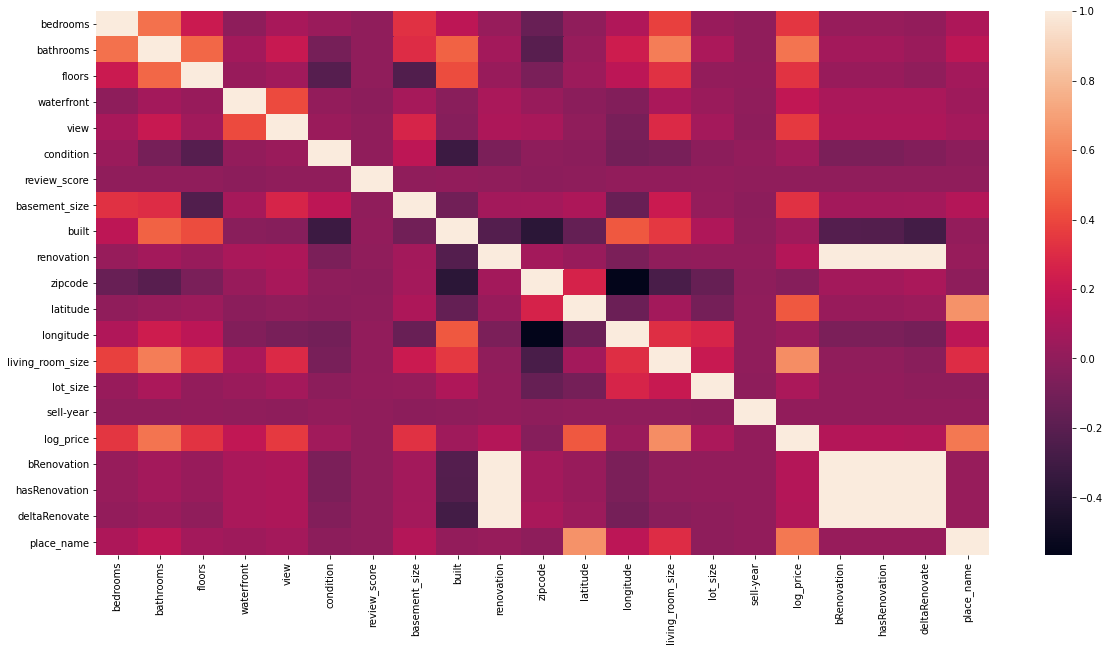

In [140]:
corr_logprice = df_6.corr()
corr_logprice = corr_logprice.drop(index=['price','id'],columns=['price','id'])
corr_logprice.sort_values(["log_price"])
f, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(corr_logprice)

Some features such as living_room_size, bathrooms, place_name fits better to a log transform price while other features like view, basement_size, bedrooms fit better to a linear price model. In general, we see physical features like living room and bathroom as well as geographic location of the property having the highest corelationship with housing prices.

## Conclusion

We transformed and analysed house price alone and with the most correlated variables, we created new features from existing features. We validate as well as demystify preconceived notion related to home value. With this insights that we gain from exploratory data analysis, we can provide better judgement and decision making to home buyers, property agents as well as renovation contractors. Next we shall perform data processing, regression and classification.